In [1]:
# Testing Pacman
import postprocess as pp
import plots as plots
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

from pathlib import Path 

postproc


In [2]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


## Analyis helps

In [3]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2


def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _α = (t/_tc - 1) / (_k - 1)
        _alphah = [_α for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_α)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_α) / (_N*a_atk(_α)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [4]:
class DefaultDamage:
    def __init__(self, state, matpar, name = "Default damage model: atk aka JJK aka LS"):
        self.state = state
        self.matpar = matpar
        self.str = name

    def _a(self, α):
        _α = self.state[α]
        # _α = α
        # _E0 = self.matpar[E0]
        _k = self.matpar[k]

        return (1 - α) / ((_k-1) * α + 1)

    def _w(self, _α):
        _α = α
        # _w1 = self.matpar[w1]

        return _α

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _E0 = self.matpar[E0]
        _u = state[u]
        _α = state[α]

        return 1./2. * _E0 * self._a(_α) * sp.diff(_u, x)**2 

    def _damage(self, state):
        _α = state[α]
        _w1 = matpar[w1]
        _η = matpar[η]

        return _w1 * (self._w(_α) + matpar[η]**2 * sp.diff(_α, x)) 


    def __str__(self):
     return self.str


class DamageATSN(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATk Damage Model, Seb Neukirch"):
        super(DefaultDamage, self).__init__(matpar, name = "Damage Model")

    def _a(self, state):
        α = state[α]
        _E0 = self.matpar[E0]

        # return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return 1-(1.-_α)**2


class DamageATn(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATn Damage Model"):
        super(DamageATn, self).__init__(state, matpar, name = "Damage Model")

    def _a(self, α):
        return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return _α**_n


class DamagePQ(DefaultDamage):
    """Particularly interesting model, as per marigo-2012"""
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - α)**_q / (1 + α)**_p  

    def _w(self, _α):
        
        
        _α = α
        _q = self._matpar[q]
        _p = self._matpar[p]
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]

        return (_p+_q) * _α * _σc**2 / _E0


class DamagePQ2(DefaultDamage):
    """Particularly interesting other model, as per marigo-2012, 
        Requires: q > p > 0
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - α)**_q 

    def _w(self, _α):
        
        _α = α
        _q = self._matpar[q]
        _p = self._matpar[p]
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]

        return _q * _σc**2 / (2.* _p * _E0)  * (1.-(1.-_α)**_p)


class PerfectBrittle(DefaultDamage):
    """Perfectly brittle model, as per marigo-2012, 
        w'/E' is constant
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        # return (1 - α)**_q 
        # return ?

    def _w(self, _α):
        
        _α = α
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]
        _ec = _σc / _E0

        return _E0 * (1 - self._a) * _ec**2 /2.


In [5]:
## Simple Analytic 
# import visuals
E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
# k = sp.symbols('k', integer = True)
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)


### Homogeneous sound solution
<!-- u = tx -->
<!-- alpha = 0 -->

In [36]:
class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""
    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(state[α])
        self._sp = sp.diff(self._s, state[α], 1)
        self._spp = sp.diff(self._s, state[α], 2)

        self._a = self.model._a(state[α])
        self._ap = sp.diff(self._a, state[α], 1)
        self._app = sp.diff(self._a, state[α], 2)

        self._w = self.model._w(state[α])
        self._wp = sp.diff(self._w, state[α])
        self._wpp = sp.diff(self._w, state[α], 2)

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0 

        _crit = sp.diff(model.energy(state), α) \
            .subs({u: _u0, α: _alpha0})         \
            .simplify()
            # .subs(matpar).simplify()
        

        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _homogeneous_energy(self, _matpar):
        state, (_uf, _af) = self._homogeneous_state(_matpar)

        _u = state[0]
        _alpha = state[1]

        return

    def critical_load(self):
        return sp.solve(self.crit, t**2, 0)

    def critical_load_N(self, _matpar = {}):
        _crits = sp.solve(t**2 - self.critical_load()[0][t**2], t)
        _crit_loads = np.where(np.array([sp.N(tc.subs(_matpar)) for tc in _crits]) > 0)
        return _crit_loads

    def set_critical_load(self, _critical_load):
        self._critical_load = _critical_load

    def _check_constitutive(self):
        _a = 1
        # a -> E(a) decreasing
        # a -> w(a) increasing
        # a -> -w'/E' increasing
        # a -> -w'/s' decreasing
        return

    def _homogeneous_alpha(self):
        _u0 = t*x/L

        try:
            _eq = sp.diff(self.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify()

            _ah = sp.solve(_eq, α)

        except NotImplementedError as e:
            _eq = sp.diff(ana.model.energy(state), α)   \
                .subs({u: _u0, α: α})                   \
                .subs(self.matpar)                   \
                .simplify()
    
            _ah = sp.solve(_eq, α)

        return _ah

    def plot_homogeneous_alpha(self, _matpar = {}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)[0][0]

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0")


        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

            axis.plot(supercritical_times, [_af(t) for t in supercritical_times], c="C0")
            # plt.plot()


        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        return fig, axis

    def plot_homogeneous_stress(self, _matpar = {}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)[0][0]

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3, 30)

        _sf = sp.lambdify(t, self._stress().subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(_times, [_sf(t) for t in _times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        return fig, axis

    def _homogeneous_state(self, _matpar = {}, ah = None):
        if ah is None:
            # Good luck with the first solution
            _ah = self._homogeneous_alpha()[0]
        else:
            _ah = ah
        try:
            _tc = self.critical_load_N(_matpar)[0][0]
        except:
            _tc = self._critical_load

        x, t = sp.symbols('x t')
        print(_tc)
        _homogeneous_alpha = sp.Piecewise((_ah, t >= _tc), (0, t < _tc))
        _homogeneous_u =  t * x / L

        _uf = sp.lambdify((t, x), _homogeneous_u.subs(_matpar), "numpy")
        _af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")

        state = {u: _homogeneous_u, α: _homogeneous_alpha}

        return state, (_uf, _af)

    def _set_homogeneous_alpha(self, ah):
        self.homogeneous_alpha = ah
        
        return

    def plot_homogeneous_energies(self, _matpar):

        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)

        _en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[1]}).subs(_matpar), "numpy")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
        plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
        plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")

        return fig, axis

    def plot_material(self):
        _damage = np.linspace(0., 1.)

        _af = sp.lambdify(α, self._a.simplify().subs(_matpar), "numpy")
        _apf = sp.lambdify(α, self._ap.simplify().subs(_matpar), "numpy")
        _appf = sp.lambdify(α, self._app.simplify().subs(_matpar), "numpy")

        # _apf = sp.lambdify(t, ana.)ap.subs(_matpar), "numpy")
        # _apf

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(α) for α in _damage], label = "a")
        _ax.legend(loc=2)
        # _ax.twiny()
        _ax.plot(_damage, [_apf(α) for α in _damage], label = "a'", c='r')
        _ax.plot(_damage, [_appf(α) for α in _damage], label = "a''")
        _ax.set_xlim(0, 1)
        _ax.legend()


        _sf = sp.lambdify(α, self._s.simplify().subs(_matpar), "numpy")
        _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")
        _sppf = sp.lambdify(α, self._spp.simplify().subs(_matpar), "numpy")


        _ax = axis[1]

        _ax.plot( _damage, [_sf(α) for α in _damage], label = "s")
        _ax.legend(loc=2)
        _ax.axhline(0, c='k')
        _ax.twinx()
        _ax.plot( _damage, [_spf(α) for α in _damage], label = "s'")
        _ax.plot( _damage, [_sppf(α) for α in _damage], label = "s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

    def _hypotheses1(self):
        """As per marigo-2012, HP1: w'/S' decreasing wrt alpha"""

        _hp1 = self._sp / self._wp
        return _hp1

    def _H_damage_profile(self):
        """A function of sigma and beta constructs localisation profiles"""
        _σ = sp.symbols('σ')
        _β = sp.symbols('β')
        
        _Hf = 1/E0*(2*ana._w - _σ**2 * (ana._s - 1/E0)).subs({α: _β})
        # _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")

        # ana._H_damage_profile().subs(_matpar).subs({α: _β})
        return _Hf      

    def _α_max(self, σ):
        _β = sp.symbols('β')
        _σ = sp.symbols('σ')
        _matpar = self.matpar
        _Hσβ = self._H_damage_profile().subs(_matpar)

        _Hβ = _Hσβ.subs({_σ: σ})
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect')
        print(_sol)
        αmax = _sol[1][0]

        return αmax

    def _stress(self, ah = None):
        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar, ah = ah)
        
        _ah = _homog_state[α]
        
        _tc = self.critical_load_N(_matpar)[0][0]

        stress_alpha = sp.Piecewise(
            (sp.sqrt( 2* self._wp / self._sp).subs({α: _ah}), t >= _tc), 
            # sigma = E(alpha=0) u'
            (sp.diff(_homog_state[u], x).subs(_matpar), t < _tc))
            
        # return sp.sqrt( 2* self._wp / self._sp).subs({α: _ah})
        return stress_alpha

    def _Dσ(self, σ):
        """Half length of the localisation as a function of σ"""
        _αh = self._homogeneous_alpha()
        _β = sp.symbols('β')
        _αmax = self._α_max(σ)


        _E0 = self.model._matpar[E0]
        _η = self.model._matpar[η]

        _f = 1/self._H_damage_profile()
        
        _Dσ = _η *  sp.integrate(_f, (_β, 0, _αmax))

    def _Dc(self):
        """Half length of the localisation at the onset"""
        _αh = self._homogeneous_alpha()
        _E0 = self.model._matpar[E0]
        _D = np.pi * η * sp.sqrt(2 * _E0 / (σ * self._spp - 2.*self._wpp)).subs({α: 0})

    def _deps_1_d_dσ(self):
        _α = self.model.state[α]
        _E0 = self.model.matpar[E0]
        # _σc = self.model.matpar[σc]
        _σc = 1.
        

        _sp = self._sp
        _w = self._w
        
        return - ((np.pi * 2**(5/2) * ((_sp) )**2 * _σc**2 * _E0**1/2) / \
            (self._spp  * _σc**2 - 2.* self._wpp) ** (3/2)).subs({α: 0})

    # check: dependence of localisation zone wrt stress
    # check: global maccro response


In [49]:
E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
k = sp.symbols('k', integer = True)

x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

state = {u: u, α: α}

# sp.diff(atk.elastic(state), α).subs({u: _u0}).simplify()



In [50]:
# _times = np.linspace(0., atk.matpar)
_times = np.linspace(0., 3.)
_damage = np.linspace(0., 1.)


### ATk

In [70]:
state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, η: η, L: 1}
matpar = {k: k, E0: 1, w1: w1, η: η, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, _matpar)


ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit




w1 - 1.0*t**2/L**2

In [71]:
# atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
ana.criterion()


w1 - 1.0*t**2/L**2

In [72]:
ana.critical_load_N(_matpar)[0][0]

1

In [73]:
ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load

In [74]:
sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

(1.0*w1*α(x)**2 + 2.0*w1*α(x) + 1.0*w1 - 1.0*t**2/L**2)/(1.0*α(x)**2 + 2.0*α(x) + 1.0)

In [76]:
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1


({u(x): t*x/L, α(x): Piecewise((-1.0 + t/(L*sqrt(w1)), t >= 1), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

(0.0, 2.0)

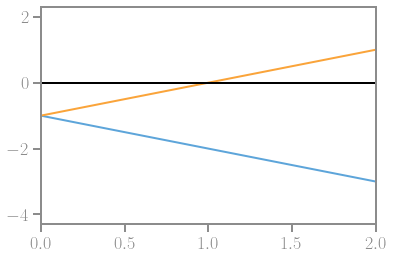

In [56]:
_eq = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _a in _ah_f:
    plt.plot(_times, [_a(t) for t in _times])

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

## Check if multiple solutions

In [57]:
ana._homogeneous_alpha()

[-1.0 - t/(L*sqrt(w1)), -1.0 + t/(L*sqrt(w1))]

In [58]:
state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1


In [59]:
_a = state[α]

_ah_f = sp.lambdify(t, _a.subs(ana.model.matpar), "numpy")
_ah_f(0)

array(0.)

(0.0, 2.0)

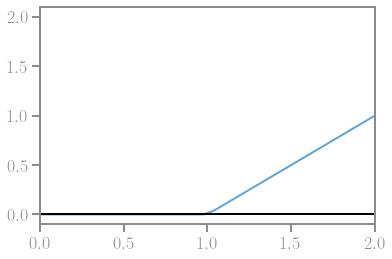

In [60]:
plt.plot(_times, [_ah_f(t) for t in _times])

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

(0.0, 2.0)

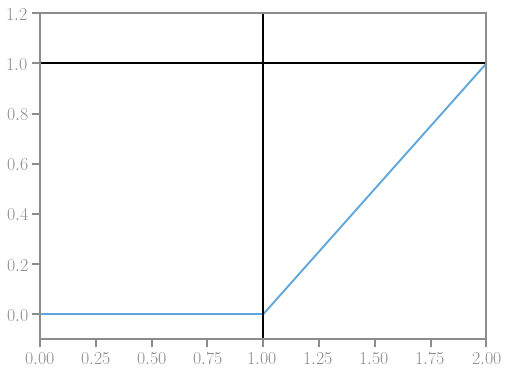

In [68]:

fig, ax = ana.plot_homogeneous_alpha(_matpar)
ax.set_ylim(-0.1, 1.2)
ax.set_xlim(0, _matpar[k])


1


(0.0, 2.0)

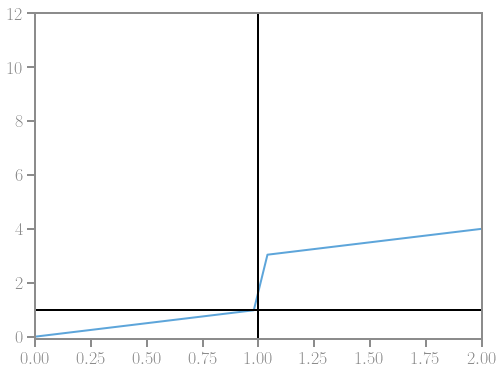

In [69]:

fig, ax = ana.plot_homogeneous_stress(_matpar)
ax.set_ylim(-0.1, 12)
ax.set_xlim(0, _matpar[k])


In [76]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)
_homog_state[α]


Piecewise(((-L*w1 - 0.707106781186548*t*sqrt(k*w1))/(L*w1*(k - 1.0)), t >= 1), (0, True))

In [77]:
atk.energy({u: _homog_state[u], α: _homog_state[α]})

KeyError: Piecewise(((-L*w1 - 0.707106781186548*t*sqrt(k*w1))/(L*w1*(k - 1.0)), t >= 1), (0, True))

In [78]:
_en_h = sp.lambdify(t, atk.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, atk._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, atk._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")


KeyError: Piecewise(((-L*w1 - 0.707106781186548*t*sqrt(k*w1))/(L*w1*(k - 1.0)), t >= 1), (0, True))

<lambdifygenerated-73>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-_Dummy_1269 - 1)/(_Dummy_1269 - 1)
<lambdifygenerated-74>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(_Dummy_1270**2 - 2*_Dummy_1270 + 1)
<lambdifygenerated-75>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -4/(_Dummy_1271**3 - 3*_Dummy_1271**2 + 3*_Dummy_1271 - 1)


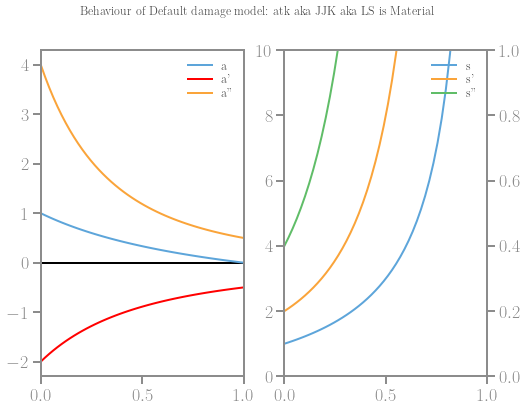

In [79]:
ana.plot_material()

In [80]:
# Localised branches
ana._s, ana._sp.simplify(), ana._spp.simplify()

(((k - 1)*α(x) + 1)/(1 - α(x)),
 k/(α(x)**2 - 2*α(x) + 1),
 -2*k/(α(x)**3 - 3*α(x)**2 + 3*α(x) - 1))

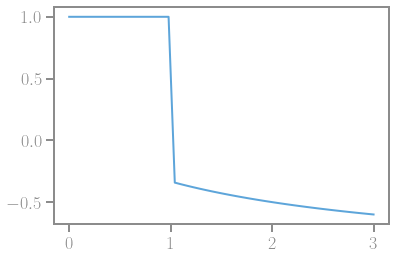

In [82]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_s = ana._s.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")


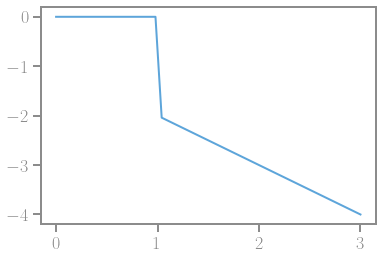

In [83]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_w = ana._w.subs({α: _homog_state[α]}).subs(_matpar)
_wf = sp.lambdify(t, _w, "numpy")

plt.plot(_times, [_wf(t) for t in _times], c="C0")


<lambdifygenerated-85>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801*(β + 1)/(1 - β)
<lambdifygenerated-86>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.814004938271605 - 0.814004938271605*(β + 1)/(1 - β)
<lambdifygenerated-87>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.66331975308642 - 0.66331975308642*(β + 1)/(1 - β)
<lambdifygenerated-88>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.528044444444444 - 0.528044444444444*(β + 1)/(1 - β)
<lambdifygenerated-89>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.408179012345679 - 0.408179012345679*(β + 1)/(1 - β)
<lambdifygenerated-90>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.303723456790123 - 0.303723456790123*(β + 1)/(1 - β)
<lambdifygenerated-91>:2: RuntimeWarning: divide by zero encountered in double_scalars
 

(-1.0, 1.0)

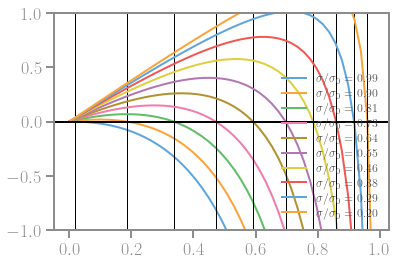

In [84]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')



for k in np.linspace(.99, .2, 10):
# for k in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: k})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    plt.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # plt.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    plt.axvline(αmax, c='k', lw=1)


plt.legend()
plt.axhline(0, c="k")
plt.ylim(-1, 1)


In [85]:



amax = []
for i in np.linspace(.99, .2, 10):
    amax.append(ana._α_max(i))


plt.plot(amax, np.linspace(1, .0, 10), marker='o')
plt.xlabel('$\\bar \\alpha$')
plt.ylabel('$\\sigma/\\sigma_0$')
plt.xlim(0., 1.)
# plt.plot(np.linspace(-.99, -.2, 10), amax)

[(0.0, _X1)]


IndexError: list index out of range

### ATn

In [11]:
## Simple Analytic 
# import visuals

E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

n = sp.symbols('n')


#### ATn, n=1 => AT1

In [12]:
state = {u: u, α: α}
matpar = {n: 1, E0: 1, w1: 1, η: η}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, η: η}

at1 = DamageATn(state, matpar={n: 1, E0: 1, w1: w1, η: η, L: L}, name="at1")
ana = ModelAnalysis(model = at1)


ana.criterion(), ana.critical_load(), ana._homogeneous_alpha()


1 - 1.0*t**2/L**2

(-0.1, 1.0)

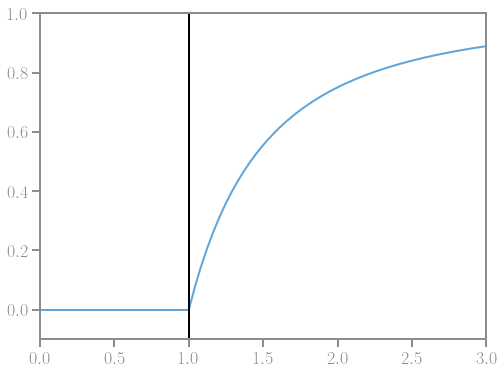

In [13]:

fig, ax = ana.plot_homogeneous_alpha(_matpar)
ax.set_ylim(-0.1, 1)


<lambdifygenerated-4>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1),True], [sqrt((1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**3),t], default=nan)


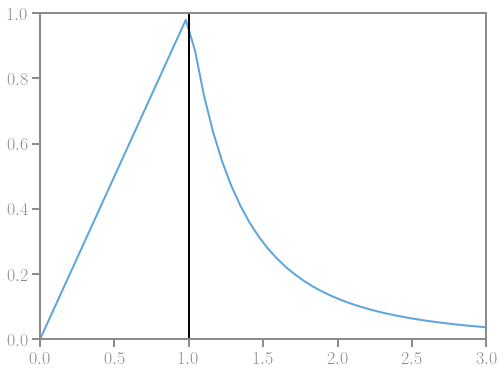

In [14]:

fig, ax = ana.plot_homogeneous_stress(_matpar)


In [15]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)
_homog_state[α]


Piecewise((-L**2/t**2 + 1.0, t >= 1), (0, True))

In [16]:
at1.energy({u: _homog_state[u], α: _homog_state[α]})

α(x) + 0.5*t**2*(1 - Piecewise((-L**2/t**2 + 1.0, t >= 1), (0, True)))**2/L**2

<lambdifygenerated-7>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**2 + select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan)
<lambdifygenerated-8>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan)
<lambdifygenerated-9>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**2


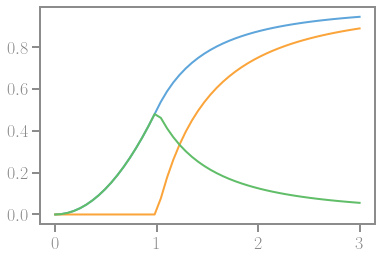

In [17]:
_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")


<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_Dummy_111 - 1)**(-2.0)
<lambdifygenerated-14>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -2/(_Dummy_112 - 1)**3
<lambdifygenerated-15>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 6/(_Dummy_113 - 1)**4


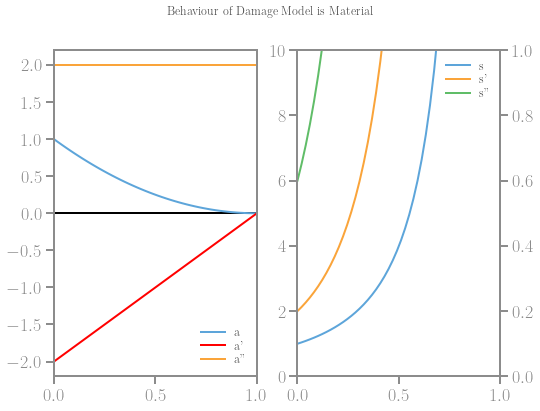

In [18]:
ana.plot_material()

In [21]:
# Localised branches
ana._s, ana._sp.simplify(), ana._spp.simplify()

((1 - α(x))**(-2), -2/(α(x) - 1)**3, 6/(α(x) - 1)**4)

<lambdifygenerated-18>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**3


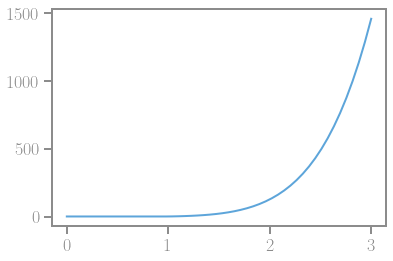

In [21]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_s = ana._sp.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")


<lambdifygenerated-18>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan)


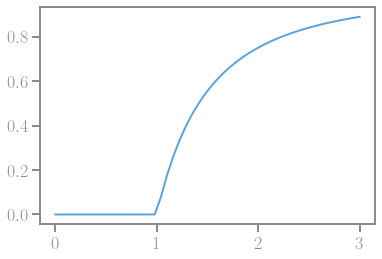

In [22]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_w = ana._w.subs({α: _homog_state[α]}).subs(_matpar)
_wf = sp.lambdify(t, _w, "numpy")

plt.plot(_times, [_wf(t) for t in _times], c="C0")


$$E_0 H(\sigma, \beta) = 2w(\beta) - \sigma^2 (S(\beta)-S_0))$$

with
$$\eta^2 \alpha'(x)^2 = H(\sigma, \alpha(x)) \qquad \qquad x\in S_i$$

$$e_\text{loc}(\sigma)=\int_0^{\bar \alpha(\sigma)} \frac{S(\beta)-S_0}{\sqrt{2w(\beta) - \sigma^2(S(\beta)-S_0))}}d\beta$$

In [30]:
ana._s

(1 - α(x))**(-2)

In [31]:
sp.diff(ana._s, α) \
    .subs({α: 0})

2

<lambdifygenerated-19>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801/(1 - β)**2
<lambdifygenerated-20>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.814004938271605 - 0.814004938271605/(1 - β)**2
<lambdifygenerated-21>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.66331975308642 - 0.66331975308642/(1 - β)**2
<lambdifygenerated-22>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.528044444444444 - 0.528044444444444/(1 - β)**2
<lambdifygenerated-23>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.408179012345679 - 0.408179012345679/(1 - β)**2
<lambdifygenerated-24>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.303723456790123 - 0.303723456790123/(1 - β)**2
<lambdifygenerated-25>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.21467777777777

(-1.0, 1.0)

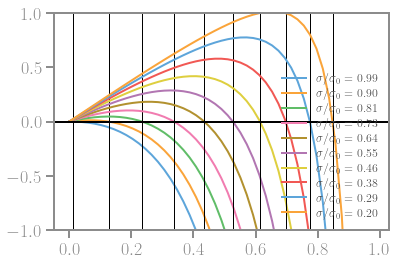

In [23]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')



for k in np.linspace(.99, .2, 10):
# for k in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: k})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    plt.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # plt.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    plt.axvline(αmax, c='k', lw=1)


plt.legend()
plt.axhline(0, c="k")
plt.ylim(-1, 1)


In [34]:

np.linspace(1., 0.)

array([1.        , 0.97959184, 0.95918367, 0.93877551, 0.91836735,
       0.89795918, 0.87755102, 0.85714286, 0.83673469, 0.81632653,
       0.79591837, 0.7755102 , 0.75510204, 0.73469388, 0.71428571,
       0.69387755, 0.67346939, 0.65306122, 0.63265306, 0.6122449 ,
       0.59183673, 0.57142857, 0.55102041, 0.53061224, 0.51020408,
       0.48979592, 0.46938776, 0.44897959, 0.42857143, 0.40816327,
       0.3877551 , 0.36734694, 0.34693878, 0.32653061, 0.30612245,
       0.28571429, 0.26530612, 0.24489796, 0.2244898 , 0.20408163,
       0.18367347, 0.16326531, 0.14285714, 0.12244898, 0.10204082,
       0.08163265, 0.06122449, 0.04081633, 0.02040816, 0.        ])

In [158]:


σv = .5
_β = sp.symbols('β')
_αmax = ana._α_max(σv)


_E0 = ana.model.matpar[E0]
_η = ana.model.matpar[η]

_f = 1/sp.sqrt(ana._H_damage_profile()).subs({_σ: σv}).subs(ana.model.matpar)

# _Dσ =  sp.integrate(_f, (_β, 0, _αmax))
# ana.model.matpar
# _αmax
# 1/_f

(0, _αmax)
_f
# sp.N(_Dσ)

[(0.0, (0.0, 1.0)), (0.578464834591373, (0.0, 1.0)), (1.29653516540863, (0.0, 1.0))]


sqrt(2)/(2*sqrt(β + 0.125 - 0.125/(1 - β)**2))

In [162]:
_αmax

0.578464834591373

In [154]:
_f = (_η*1/sp.sqrt(ana._H_damage_profile())).subs(ana.model.matpar).subs({_σ: σv, η: .1})
_f

0.05*sqrt(2)/sqrt(β + 0.32 - 0.32/(1 - β)**2)

In [161]:
_f.subs({_β: 0.000001})

577.350413531778*sqrt(2)

In [147]:
_fv = sp.lambdify(_β, _f, "numpy")
_beta = np.linspace(0., np.float64(_αmax), 10)
# _beta
[_fv(b) for b in _beta]

<lambdifygenerated-95>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.05*sqrt(2)/sqrt(β + 0.405 - 0.405/(1 - β)**2)


[inf,
 1.4198445928507244,
 1.062902744821545,
 0.9281524075913692,
 0.8716905883783043,
 0.862790575573251,
 0.9000066083189326,
 1.0097065589173468,
 1.3213082406217636,
 inf]

In [148]:

np.trapz([_fv(b) for b in _beta], _beta)

inf

In [48]:

amax = []
for i in np.arange(2, 8):
    amax.append(ana._α_max(1/i))

In [171]:
ana.model.matpar

{n: 1, E0: 1, w1: w1, η: η, L: L}

In [184]:
ana._α_max(.9)

[(0.0, (0.0, 1.0)), (0.129663006415488, (0.0, 1.0)), (1.46533699358451, (0.0, 1.0))]


0.129663006415488

(1 - α(x))**(-2) - 1/E0

In [244]:
def _eps_1_d(sigma):
    _α_max = ana._α_max(sigma)
    _f = (ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile())   \
        .simplify()
    # \
            # .subs(ana.model.matpar)         \
            # .subs({_σ: sigma})


    return (_f) 

_integrand = _eps_1_d(.9)

_integrand.subs(ana.model.matpar).simplify()




[(0.0, (0.0, 1.0)), (0.129663006415488, (0.0, 1.0)), (1.46533699358451, (0.0, 1.0))]


(1 - (β - 1)**2)/(sqrt((-σ**2 + (β - 1)**2*(2*β + σ**2))/(β - 1)**2)*(β - 1)**2)

In [246]:
__integrandv = sp.lambdify(_β, _integrand, "numpy")
__integrandv(0.)


Behaviour around $\beta=0$

$$\frac{\partial f}{\partial \beta}|_{\beta=0}$$

with $f = 1/\sqrt{H(\sigma, \beta)}$

In [196]:
sp.diff(_f, _β).simplify().subs({ _β: 0})

E0*(1 - σ**2)/(σ**2*sqrt(-σ**2*(E0 - 1)/E0**2)*(E0 - 1))

In [197]:
sp.diff(_f, _β).simplify().subs({ _β: 0}).subs(ana.model.matpar)

zoo*(1 - σ**2)/σ**2

In [42]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')
sigmav = .8

_f = ((ana._s - 1/E0).subs({α: _β}) * 1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(ana.model.matpar)                                                \
    .subs({_σ: sigmav, η: .1})
_fvβ = sp.lambdify(_β, _f, "numpy")


# _α_max = ana._α_max(sigmav)
# 
print(_α_max.subs(ana.model.matpar))

_x = np.linspace(0.1, .3)
_fvβ(_x)


# np

0.252122461732037


<lambdifygenerated-38>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.32 - 0.32/(1 - β)**2)


array([ 1.05031703,  1.09049072,  1.13178395,  1.17430101,  1.21815408,
        1.26346467,  1.31036524,  1.35900097,  1.409532  ,  1.4621359 ,
        1.51701067,  1.57437833,  1.63448927,  1.69762748,  1.76411707,
        1.83433032,  1.90869767,  1.98772056,  2.07198761,  2.16219576,
        2.25917793,  2.36393978,  2.47770953,  2.60200646,  2.73873726,
        2.89033447,  3.05996084,  3.2518203 ,  3.47164825,  3.72751809,
        4.0312376 ,  4.40092493,  4.86615951,  5.47943802,  6.34572512,
        7.7178545 , 10.45474401, 22.97158974,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

In [205]:
ana.model.matpar


{n: 1, E0: 1, w1: w1, η: η, L: L}

In [222]:
ana._deps_1_d_dσ()

-2.41839915231229

(0.0, 1.0)

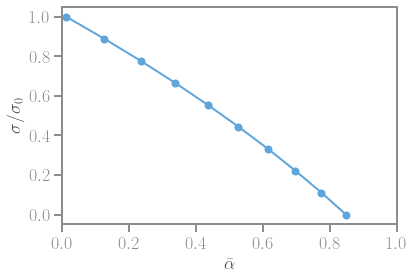

In [67]:



amax = []
for i in np.linspace(.99, .2, 10):
    amax.append(ana._α_max(i))


plt.plot(amax, np.linspace(1, .0, 10), marker='o')
plt.xlabel('$\\bar \\alpha$')
plt.ylabel('$\\sigma/\\sigma_0$')
plt.xlim(0., 1.)
# plt.plot(np.linspace(-.99, -.2, 10), amax)

In [221]:
- np.pi * 2**(5/2) * (ana._sp**2 / (ana._spp - 2*ana._wpp)**(3/2)).subs({α: 0})
# return - ((np.pi * 2**(5/2) * ((_sp) )**2 * _σc**2 * _E0**1/2) / \
#     (self._spp  * _σc**2 - 2.* self._wpp) ** (3/2)).subs({α: 0})

-4.83679830462458

### PQ

In [223]:
state = {u: u, α: α}
p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')

# _matpar = {n: 1, L: 1, E0: 1, w1: 1, η: η}

dpq = DamagePQ(state, matpar={}, name="pq")
ana = ModelAnalysis(model = dpq)
ana.criterion()


(p + q)*(-0.5*E0**2*t**2/L**2 + σc**2)/E0

In [225]:
ana._deps_1_d_dσ()

-8.88576587631673*E0*(p + q)**2/(2*p*q + p*(p - 1) + q*(q + 1))**1.5

In [159]:
ana._deps_1_d_dσ() \
    .subs({E0: 1, σc: 1})

-8.88576587631673*(p + q)**2/(p**3 + 3*p**2*q - 3*p**2 + 3*p*q**2 + 2*p + q**3 + 3*q**2 + 2*q)**1.5